# Asian options
Recall that a European call option is a contract whose payoff at expiration is given by $\max(s_t - K, 0)$, where $K$ is the predetermined strike price and $s_t$ is the asset value at expiration time $t$.  By design, European call options are then path-independent, but also susceptible to "last-minute" volatility.

Asian call (put) options are an alternative contract trying to address the European option's susceptibility to short-term volatility, by defining the payoff at expiration to be $\max(\bar{S} - K, 0)$ ($\max(K - \bar{S}, 0)$), where $\bar{S}$ is either the arithmetic average of the stock prices $\bar{S} = \frac{1}{N} \sum_{i=1}^N S_{t_i}$ or the geometric average $\bar{S} = \left(\prod_{i=1}^N S_{t_i} \right)^{1/N}$, where $N$ is the number of subdivisions of the time interval $[0,t]$.

As such, Asian options are path-dependent.  The geometric Asian option has a closed-form solution, while the arithmetic Asian option has not.  We will model both via Monte-Carlo methods, and compare the geometric simulated price with the computed price.

In a later notebook, we will also explore some delta-hedging strategies for arithmetic Asian options.

### Geometric Asian options
We first consider Asian options whose value at expiration is given by $\max(\bar{S} - K, 0)$, where $\bar{S}$ is the geometric average of the process $S_t$.

>**Note.** The closed-form solution for fair pricing of geometric Asian options assumes that $\bar{S}$ is the continuous-time geometric average.  In reality, it will be a geometric average sampled at $N$ points.  If $N$ is sufficiently large, that should give a good enough approximation.

##### Closed-form solution

>**Theorem.** Assume that $S_t$ follows a GBM distribution with yearly volatility $\sigma$.  Assume also that the risk-free interest rate is $r$.  Let $K$ be the strike price and set 
>$$
>b = \frac{1}{2} \left(r - \frac{\sigma^2}{6} \right), \quad d_1 = \sqrt{3}\frac{\log\frac{S_0}{K} + \left(b + \frac{\sigma^2}{6}\right)t}{\sigma\sqrt{t}}, \quad d_2 = d_1 - \frac{\sigma \sqrt{t}}{\sqrt{3}}.
>$$
>Then the fair price for a geometric Asian call option at time $t$ is
>$$
>C_0 = S_0 e^{(b-r)t} \Phi(d_1) - K e^{-rt} \Phi(d_2)
>$$
>and the fair price for a geometric Asian put option at time $t$ is
>$$
>P_0 = K e^{-rt} \Phi(-d_2) - S_0 e^{(b-r)t} \Phi(-d_1).
>$$
>Note that we still have put-call parity:
>$$
>C_0 - P_0 = S_0 e^{(b-r)t} - K e^{-rt}.
>$$

We implement the geometric Asian option pricing via the following code, available in `utils.py`.
```python
# Geometric Asian option
def gao_price(S0, K, sigma, t, r, option_type='call'):
    '''Geometric Asian option pricer
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate

    Return:
    Computed value of a geometric Asian call/put option (float)
    '''
    b = (r - sigma**2 / 6) / 2
    d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t/3)

    if option_type == 'put':
        return K * np.exp(-r*t) * norm.cdf(-d2) - S0 * np.exp((b-r)*t) * norm.cdf(-d1)
    elif option_type == 'call':
        return S0 * np.exp((b-r)*t) * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))
```

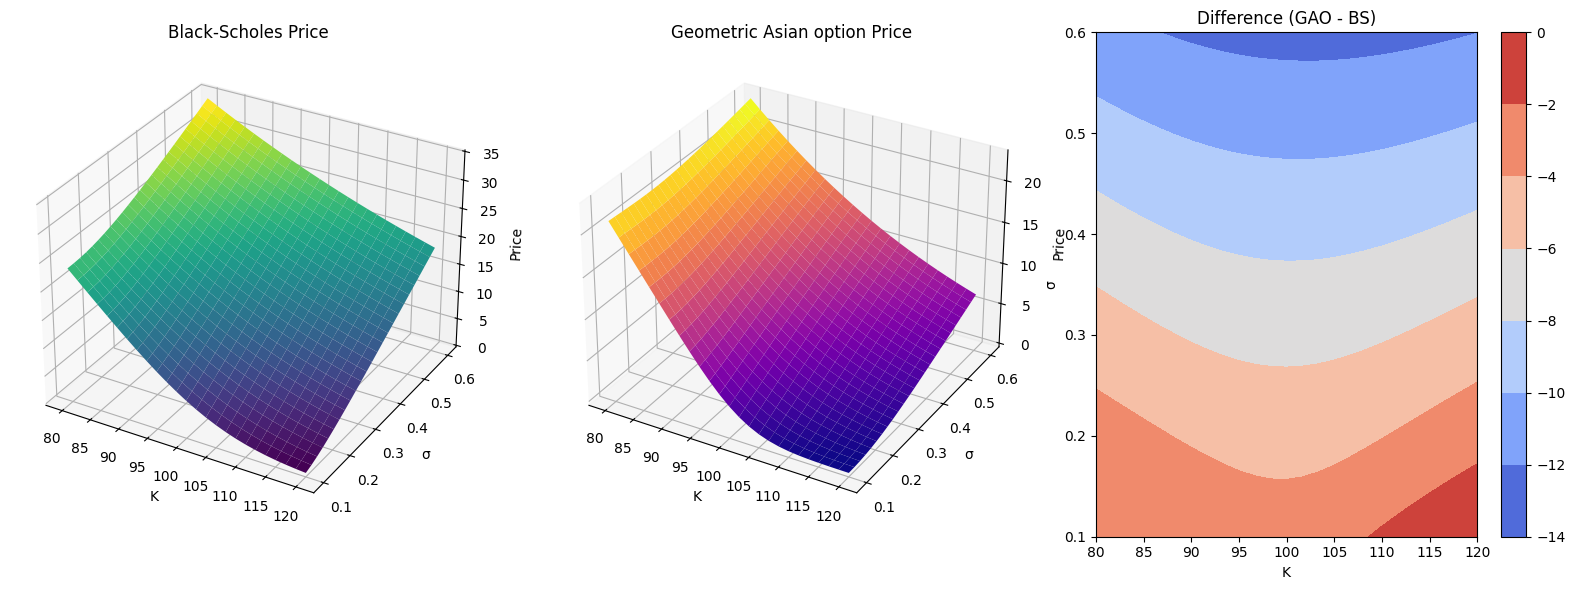

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

from utils import bs_price, gao_price

S0 = 100
t = 1.0
r = 0.045

K_values = np.linspace(80, 120, 25)
sigma_values = np.linspace(0.1, 0.6, 25)


# Compare bs_price and gao_price over K and sigma, fixing t and r
K, sigma = np.meshgrid(K_values, sigma_values)

bs = np.vectorize(bs_price)(S0, K, sigma, t, r)
gao = np.vectorize(gao_price)(S0, K, sigma, t, r)
diff = gao - bs

fig = plt.figure(figsize=(16, 6))

# --- 3D Surface: BS price ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(K, sigma, bs, cmap="viridis")
ax1.set_title("Black-Scholes Price")
ax1.set_xlabel("K")
ax1.set_ylabel("σ")
ax1.set_zlabel("Price")

# --- 3D Surface: GAO price ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(K, sigma, gao, cmap="plasma")
ax2.set_title("Geometric Asian option Price")
ax2.set_xlabel("K")
ax2.set_ylabel("σ")
ax2.set_zlabel("Price")

# --- Heatmap: Difference ---
ax3 = fig.add_subplot(133)
c = ax3.contourf(K, sigma, diff, cmap="coolwarm")
plt.colorbar(c, ax=ax3)
ax3.set_title("Difference (GAO - BS)")
ax3.set_xlabel("K")
ax3.set_ylabel("σ")

plt.tight_layout()
plt.show()

Note how the Asian option is, as expected, less susceptible of volatility increases.  Note also that Asian options are cheaper than European options, and that the difference in prices becomes greater as volatility increases.

##### Monte-Carlo simulation
As with European options, we can estimate the fair price by Monte-Carlo methods.

In [2]:
from utils import GBM_paths

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")


def monte_carlo_gao(S0, K, sigma, t, r, mu, n_sims, n_steps, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths

    Returns:
    Estimated option price (float), standard deviation (float)
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    S = np.exp(np.mean(np.log(paths), axis=1))  # geometric mean of prices

    if option_type == "call":
        payoffs = np.maximum(S - K, 0)
    elif option_type == "put":
        payoffs = np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    discounted_payoff = np.exp(-r * t) * payoffs

    return np.mean(discounted_payoff), np.std(discounted_payoff) / np.sqrt(n_sims)

We can then compare how the Monte-Carlo simulation stacks up against the closed-form formula.  In this case, we also need to specify the number of steps.  Since we are looking at a 1-year horizon, we take `n_steps` to be 252.

In [3]:
simulations = [10, 100, 1_000, 10_000, 100_000, 1_000_000]

S0 = 100
r = 0.0425
t = 1
K = S0
sigma = 0.43
mu = 0
n_steps = 252

analytic_price = gao_price(S0, K, sigma, t, r)
print(f"Computed fair price: ${analytic_price:.2f}")

for n_sims in simulations:
    call_value, std_err = monte_carlo_gao(S0, K, sigma, t, r, mu, n_sims, n_steps)
    print(
        f"Estimated call value with {n_sims} simulations: ${call_value:.2f} with standard error \
{std_err:.5f}"
    )

Computed fair price: $9.78
Estimated call value with 10 simulations: $8.68 with standard error 2.94802
Estimated call value with 100 simulations: $9.26 with standard error 1.91080
Estimated call value with 1000 simulations: $9.66 with standard error 0.49850
Estimated call value with 10000 simulations: $9.56 with standard error 0.16094
Estimated call value with 100000 simulations: $9.69 with standard error 0.05152
Estimated call value with 1000000 simulations: $9.78 with standard error 0.01641


As before, the Monte-Carlo price converges to the computed fair price as the number of simulations increases.  Where possible, we will settle for 100,000 simulations for a good balance of accuracy and computational speed (otherwise we will use 10,000 as the best alternative).

### Arithmetic Asian options
If the value of the call (put) option is given by $\max(\bar{S} - K, 0)$ ($\max(K-\bar{S}, 0)$, respectively) with $\bar{S}$ the arithmetic mean, then we have no closed-form solution, and we need to resort to Monte-Carlo methods.

The following code is available in `utils.py`, and comprehends both geometric and arithmetic Asian options.

```python
def monte_carlo_asian(S0, K, sigma, t, r, mu, n_sims, n_steps, geometric=False, return_distribution=True, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    If return_distribution is true, returns distribution of simulated values;
      if false, returns the average payoff of option
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    if geometric:
        S = gmean(paths, axis=1)  # geometric mean of prices
    else:
        S = np.mean(paths, axis=1)  # arithmetic mean of prices

    if option_type == "call":
        discounted_payoff = np.exp(-r * t) * np.maximum(S - K, 0)
    elif option_type == "put":
        discounted_payoff = np.exp(-r * t) * np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    if return_distribution:
        return discounted_payoff
    else:
        return np.mean(discounted_payoff)
```

The simulated distribution of profits of Asian call options is then as follows (from the point of view of the option buyer).

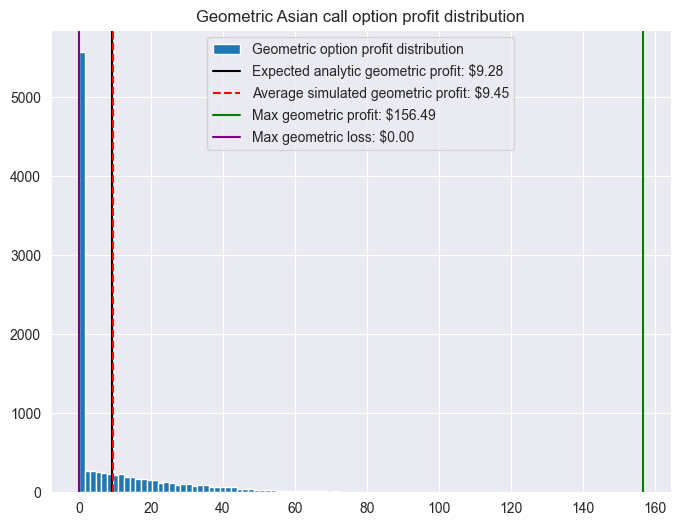

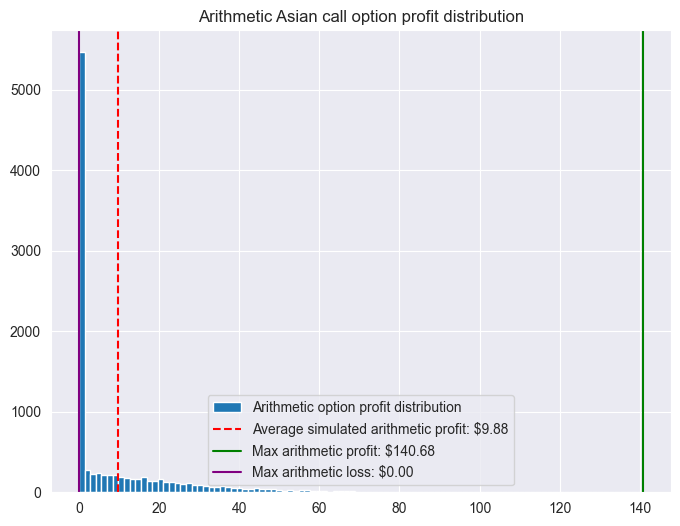

In [4]:
from utils import monte_carlo_asian

S0 = 100
K = 100
sigma = 0.4
t = 1
mu = 0
r = 0.045
n_sims = 10_000
n_steps = 252

geom_profit = monte_carlo_asian(S0, K, sigma, t, r, mu, n_sims, n_steps, geometric=True)
geom_analytic_price = gao_price(S0, K, sigma, t, r)
average_geom_profit = np.mean(geom_profit)
max_geom_profit = np.max(geom_profit)
min_geom_profit = np.min(geom_profit)

arit_profit = monte_carlo_asian(S0, K, sigma, t, r, mu, n_sims, n_steps)
average_arit_profit = np.mean(arit_profit)
max_arit_profit = np.max(arit_profit)
min_arit_profit = np.min(arit_profit)

plt.figure(figsize=(8, 6))
plt.title("Geometric Asian call option profit distribution")

plt.hist(geom_profit, bins=100, label="Geometric option profit distribution")
plt.axvline(
    geom_analytic_price,
    color="black",
    lw=1.5,
    label=f"Expected analytic geometric profit: ${geom_analytic_price:.2f}",
)
plt.axvline(
    average_geom_profit,
    ls="--",
    color="red",
    label=f"Average simulated geometric profit: ${average_geom_profit:.2f}",
)
plt.axvline(
    max_geom_profit,
    color="green",
    label=f"Max geometric profit: ${max_geom_profit:.2f}",
)
plt.axvline(
    min_geom_profit, color="purple", label=f"Max geometric loss: ${min_geom_profit:.2f}"
)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.title("Arithmetic Asian call option profit distribution")

plt.hist(arit_profit, bins=100, label="Arithmetic option profit distribution")
plt.axvline(
    average_arit_profit,
    ls="--",
    color="red",
    label=f"Average simulated arithmetic profit: ${average_arit_profit:.2f}",
)
plt.axvline(
    max_arit_profit,
    color="green",
    label=f"Max arithmetic profit: ${max_arit_profit:.2f}",
)
plt.axvline(
    min_arit_profit,
    color="purple",
    label=f"Max arithmetic loss: ${min_arit_profit:.2f}",
)

plt.legend()
plt.show()

Note that the arithmetic option seems to have higher profit than the geometric counterpart.  We can explore this further by comparing the simulated returns of geometric and arithmetic Asian options directly.

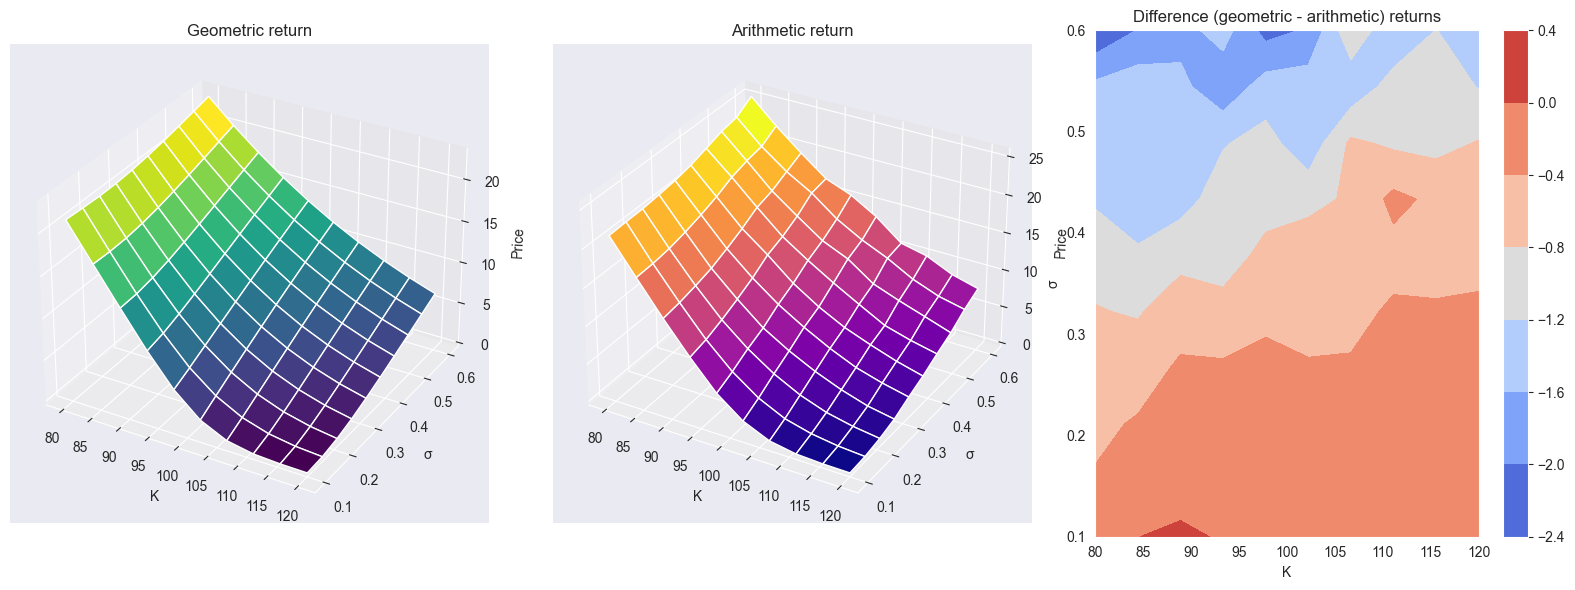

In [5]:
S0 = 100
t = 1
mu = 0
r = 0.045
n_sims = 10_000
n_steps = 252

K_values = np.linspace(80, 120, 10)
sigma_values = np.linspace(0.1, 0.6, 10)

# Compare geometric and arithmetic Asian options prices over K and sigma, fixing t and r
K, sigma = np.meshgrid(K_values, sigma_values)

geometric = np.vectorize(gao_price)(S0, K, sigma, t, r)
arithmetic = np.vectorize(monte_carlo_asian)(
    S0, K, sigma, t, r, mu, n_sims, n_steps, return_distribution=False
)
diff = geometric - arithmetic

fig = plt.figure(figsize=(16, 6))

# --- 3D Surface: BS price ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(K, sigma, geometric, cmap="viridis")
ax1.set_title("Geometric return")
ax1.set_xlabel("K")
ax1.set_ylabel("σ")
ax1.set_zlabel("Price")

# --- 3D Surface: GAO price ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(K, sigma, arithmetic, cmap="plasma")
ax2.set_title("Arithmetic return")
ax2.set_xlabel("K")
ax2.set_ylabel("σ")
ax2.set_zlabel("Price")

# --- Heatmap: Difference ---
ax3 = fig.add_subplot(133)
c = ax3.contourf(K, sigma, diff, cmap="coolwarm")
plt.colorbar(c, ax=ax3)
ax3.set_title("Difference (geometric - arithmetic) returns")
ax3.set_xlabel("K")
ax3.set_ylabel("σ")

plt.tight_layout()
plt.show()

Note that arithmetic options have a higher return than geometric ones, which should be expected since geometric means are bounded above by arithmetic means.

Arithmetic options look also more susceptible to volatility, which can be explained by the fact that geometric averages are more susceptible to small prices and less to large prices than arithmetic averages.  In fact, there seems to be a significant correlation between the difference in returns and volatility, with difference in returns being higher for higher volatility.

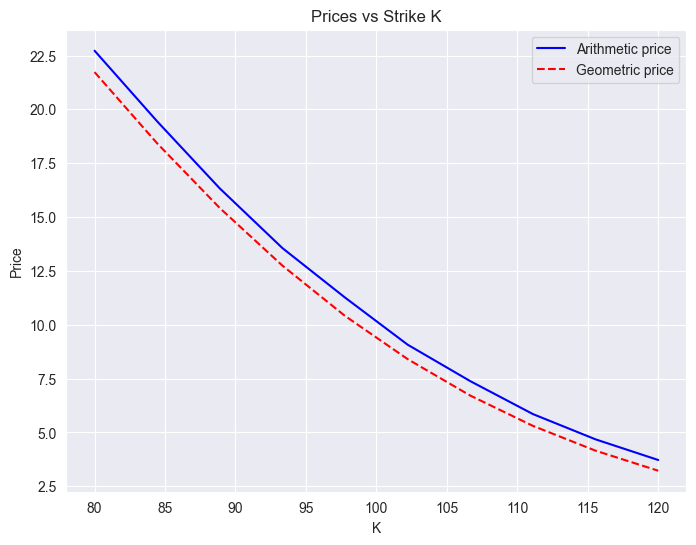

/home/roberto/Desktop/Learning/Quant finance bootcamp/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


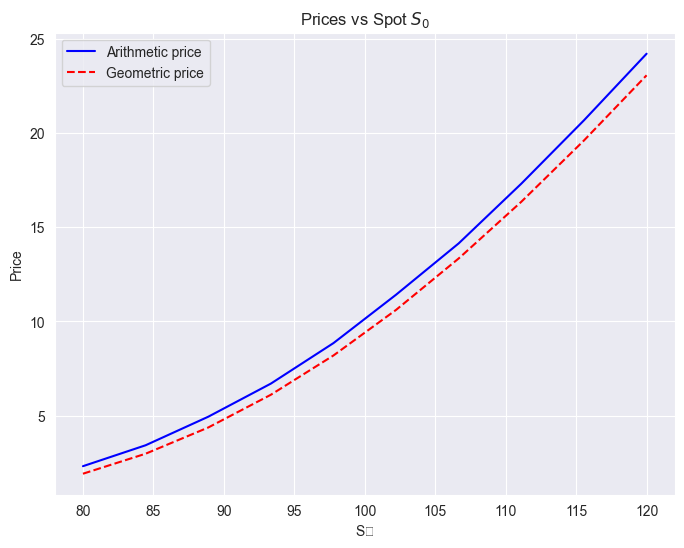

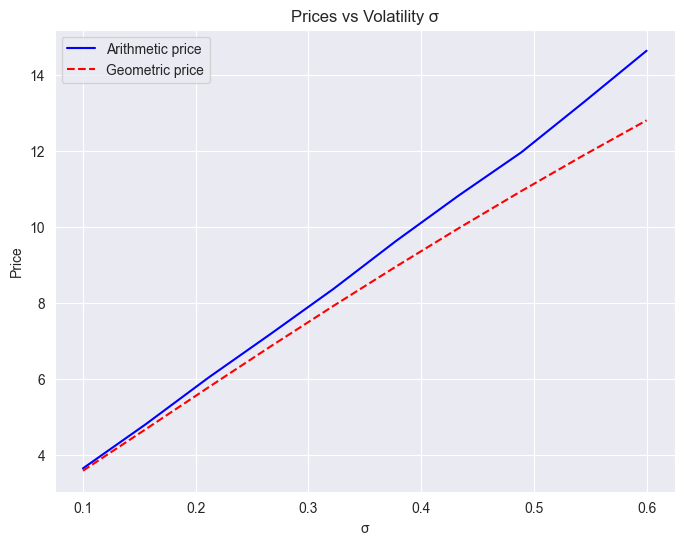

In [6]:
S0_default = 100
K_default = 100
sigma_default = 0.4
t = 1.0
r = 0.05
n_sims = 100_000
n_steps = 252
mu = 0

# --- Parameter ranges ---
K_values = np.linspace(80, 120, 10)
S0_values = np.linspace(80, 120, 10)
sigma_values = np.linspace(0.1, 0.6, 10)

# --- Compute prices for each variable ---
aao_K = [
    monte_carlo_asian(
        S0_default,
        K,
        sigma_default,
        t,
        r,
        mu,
        n_sims,
        n_steps,
        return_distribution=False,
    )
    for K in K_values
]
gao_K = [gao_price(S0_default, K, sigma_default, t, r) for K in K_values]

aao_S0 = [
    monte_carlo_asian(
        S0,
        K_default,
        sigma_default,
        t,
        r,
        mu,
        n_sims,
        n_steps,
        return_distribution=False,
    )
    for S0 in S0_values
]
gao_S0 = [gao_price(S0, K_default, sigma_default, t, r) for S0 in S0_values]

aao_sigma = [
    monte_carlo_asian(
        S0_default,
        K_default,
        sigma,
        t,
        r,
        mu,
        n_sims,
        n_steps,
        return_distribution=False,
    )
    for sigma in sigma_values
]
gao_sigma = [gao_price(S0_default, K_default, sigma, t, r) for sigma in sigma_values]


# --- Plot vs K ---
plt.figure(figsize=(8, 6))
plt.plot(K_values, aao_K, label="Arithmetic price", color="blue")
plt.plot(K_values, gao_K, label="Geometric price", color="red", linestyle="--")
plt.title("Prices vs Strike K")
plt.xlabel("K")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot vs S0 ---
plt.figure(figsize=(8, 6))
plt.plot(S0_values, aao_S0, label="Arithmetic price", color="blue")
plt.plot(S0_values, gao_S0, label="Geometric price", color="red", linestyle="--")
plt.title("Prices vs Spot $S_0$")
plt.xlabel("S₀")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot vs sigma ---
plt.figure(figsize=(8, 6))
plt.plot(sigma_values, aao_sigma, label="Arithmetic price", color="blue")
plt.plot(sigma_values, gao_sigma, label="Geometric price", color="red", linestyle="--")
plt.title("Prices vs Volatility σ")
plt.xlabel("σ")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()